# LIBRARIES TO BE USED

In [275]:
# To import dataset and manage using Githube.com ( https://github.com/viniciusparede/house-prices-prediction-ppgia )
import os
import git

# Data Manipulation
import pandas as pd
import numpy as np

# set the display option to show all columns
pd.set_option("display.max_columns", None)


import math
from scipy.stats import mode
from sklearn.neighbors import KNeighborsRegressor
from skrebate import ReliefF
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix


# Charts and visualization
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker

# Weka libraries
import weka.core.jvm as jvm
from weka.core.converters import Loader
from weka.classifiers import Classifier, Evaluation
from weka.attribute_selection import AttributeSelection
from weka.core.classes import Random

In [276]:




# Machine Learning algorithmics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Weka libraries
import weka.core.jvm as jvm
from weka.core.converters import Loader
from weka.classifiers import Classifier, Evaluation
from weka.attribute_selection import AttributeSelection
from weka.core.classes import Random

# Functions

In [277]:
# Função para encontrar diretório do repositório git
def get_git_root(path: str) -> str:
    git_repo = git.Repo(path, search_parent_directories=True)
    git_root = git_repo.git.rev_parse("--show-toplevel")
    return git_root


def encode_categorical(df: pd.DataFrame) -> pd.DataFrame:
    """
    Converte atributos numéricos discretos de um DataFrame

    :param df: DataFrame do Pandas para conversão
    """
    # Instanciar um objeto LabelEncoder
    le = LabelEncoder()

    # Iterar sobre todas as colunas do DataFrame
    for col in df.columns:
        # Verificar se a coluna é do tipo "object", o que geralmente indica
        # uma coluna categórica com strings
        if df[col].dtype == "object":
            # Se for uma coluna categórica, use o LabelEncoder para ajustar
            # e transformar os dados, substituindo os valores originais
            # pelos valores codificados como números inteiros
            df[col] = le.fit_transform(df[col])

    # Retornar o DataFrame com as colunas categóricas codificadas
    return df


def pandas2arff(
    df, filename, wekaname="pandasdata", cleanstringdata=True, cleannan=True
):
    """
    converts the pandas dataframe to a weka compatible file
    df: dataframe in pandas format
    filename: the filename you want the weka compatible file to be in
    wekaname: the name you want to give to the weka dataset (this will be visible to you when you open it in Weka)
    cleanstringdata: clean up data which may have spaces and replace with "_", special characters etc which seem to annoy Weka.
                     To suppress this, set this to False
    cleannan: replaces all nan values with "?" which is Weka's standard for missing values.
              To suppress this, set this to False
    """
    import re

    def cleanstring(s):
        if s != "?":
            return re.sub("[^A-Za-z0-9]+", "_", str(s))
        else:
            return "?"

    dfcopy = df  # all cleaning operations get done on this copy

    if cleannan != False:
        dfcopy = dfcopy.fillna(
            -999999999
        )  # this is so that we can swap this out for "?"
        # this makes sure that certain numerical columns with missing values don't get stuck with "object" type

    # Diretório do repositório git
    git_dir = get_git_root(os.getcwd())

    # Diretório de arquivos de dados
    data_dir = os.path.join(git_dir, "data")

    f = open(os.path.join(data_dir, filename), "w")
    arffList = []
    arffList.append("@relation " + wekaname + "\n")
    # look at each column's dtype. If it's an "object", make it "nominal" under Weka for now (can be changed in source for dates.. etc)
    for i in range(df.shape[1]):
        if dfcopy.dtypes[i] == "O" or (df.columns[i] in ["Class", "CLASS", "class"]):
            if cleannan != False:
                dfcopy.iloc[:, i] = dfcopy.iloc[:, i].replace(
                    to_replace=-999999999, value="?"
                )
            if cleanstringdata != False:
                dfcopy.iloc[:, i] = dfcopy.iloc[:, i].apply(cleanstring)
            _uniqueNominalVals = [str(_i) for _i in np.unique(dfcopy.iloc[:, i])]
            _uniqueNominalVals = ",".join(_uniqueNominalVals)
            _uniqueNominalVals = _uniqueNominalVals.replace("[", "")
            _uniqueNominalVals = _uniqueNominalVals.replace("]", "")
            _uniqueValuesString = "{" + _uniqueNominalVals + "}"
            arffList.append("@attribute " + df.columns[i] + _uniqueValuesString + "\n")
        else:
            arffList.append("@attribute " + df.columns[i] + " real\n")
            # even if it is an integer, let's just deal with it as a real number for now
    arffList.append("@data\n")
    for i in range(dfcopy.shape[0]):  # instances
        _instanceString = ""
        for j in range(df.shape[1]):  # features
            if dfcopy.dtypes[j] == "O":
                _instanceString += '"' + str(dfcopy.iloc[i, j]) + '"'
            else:
                _instanceString += str(dfcopy.iloc[i, j])
            if j != dfcopy.shape[1] - 1:  # if it's not the last feature, add a comma
                _instanceString += ","
        _instanceString += "\n"
        if cleannan != False:
            _instanceString = _instanceString.replace(
                "-999999999.0", "?"
            )  # for numeric missing values
            _instanceString = _instanceString.replace(
                '"?"', "?"
            )  # for categorical missing values
        arffList.append(_instanceString)
    f.writelines(arffList)
    f.close()
    del dfcopy
    return True


def evaluation_to_dataframe(predictions: list) -> pd.DataFrame:
    # Criar lista de dicionários com informações de previsão e distribuição usando list comprehension
    prediction_dict_list = [
        {
            "predicted": nominal_prediction.predicted,
            "actual": nominal_prediction.actual,
            "distribution": nominal_prediction.distribution.tolist(),
            "weight": nominal_prediction.weight,
        }
        for nominal_prediction in predictions
    ]

    # Gerar dataframe pandas a partir da lista de dicionários
    predictions_df = pd.DataFrame(prediction_dict_list)

    # Adicionar coluna que indica se a previsão foi correta ou não
    predictions_df["correct"] = predictions_df["predicted"] == predictions_df["actual"]

    return predictions_df

# LOAD DATA SET FROM GITHUB

In [278]:
# Diretório do repositório git
git_dir = get_git_root(os.getcwd())

# Diretório dos dados
data_dir = os.path.join(git_dir, "data")

# Leitura dos arquivos de treinamento e teste
df_train = pd.read_csv(os.path.join(data_dir, "train.csv"))
test_input = pd.read_csv(os.path.join(data_dir, "test.csv"))
sample_output = pd.read_csv(os.path.join(data_dir, "sample_submission.csv"))

# merge entre dataframes
df_test = pd.merge(test_input, sample_output, how="inner", on="Id")

In [279]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [280]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,169277.052498
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,187758.393989
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,NaN,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,183583.683570
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,179317.477511
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,NaN,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,150730.079977


# GROUP OF QUESTIONS #1:
# DATASET DESCRIPTION (DESCRIÇÃO DA BASE DE DADOS)

1) Indicar o nome da base:

House Prices ( https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/rules )


2) Que tipo de dado (ou problema) caracteriza esta base de dados, ou seja, o que se pretende extrair de conhecimento a partir dos dados lá disponíveis (classificação/regressão, agrupamento, associação, por exemplo):

Classificação/regressão e agrupamento


3) Indicar quem forneceu esta base, além da data da coleta dos dados (início e final), além de particularidades (por exemplo, a coleta foi interrompida durante um período de tempo e depois retomada):

O próprio site da Kaggle forneceu a base de dados como forma de competição. Mesmo analisando os metadados da base e o arquivo “data_description.txt”, não foi possível identificar a data de coleta dos dados e a data de criação da base de dados


4) Indicar se existem informações já publicadas sobre seu uso e, em caso positivo, onde foi publicado, por quem, o quê:

Sim, há publicações prévias e devido ao fato da base ser uma base de competição, existem vários notebooks já publicados, no próprio site do Kaggle ( https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/code?competitionId=5407&sortBy=scoreAscending )



5) Quantas classes existem e quais são elas, no caso de classificação, ou o nome e a faixa de valores da variável a ser prevista no caso de regressão:

Existem 81 classes/colunas/atributos no arquivo com diversos tipos de variáveis.  numéricas (sejam intervalos ou ratios) e categóricas (nominais ou ordinais). As faixas de valores e tipos de variáveis podem ser vistos no arquivo "data_description.txt".




# GROUP OF QUESTIONS #2:
# DATASET FEATURES (CARACTERÍSTICAS DA BASE DE DADOS)

There are 14 question in this group and each question will be in it own markdown field below.

1) Quantas instâncias existem?

Existe 1460 instâncias, conforme código abaixo.


2) Quantos atributos existem?

Existem 81 atributos/colunas, conforme código abaixo.

In [281]:
print(df_train.shape) #Check size of df_train

(1460, 81)


3) O tipo de cada atributo?

Vide na lista (Dtype) e no gráfico abaixo, sendo que "int64" e "float64" são variáveis numéricas e "objects" são variáveis categóricas.

In [282]:
df_train.info() #Check the df_train properties, including the type of each atribute/column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

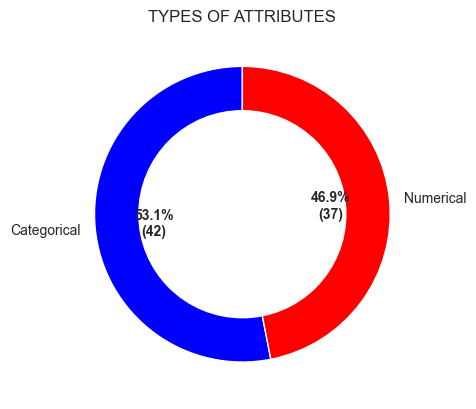

In [283]:
# ACCOUNTING THE TYPES OF ATTRIBUTES

dtypes_count = df_train.dtypes.replace(
    {"float64": "Numerical", "int64": "Numerical", "object": "Categorical"}
).value_counts()

### Create a chart to show it
sizes = dtypes_count.values
labels = dtypes_count.index.astype(str)
colors = ["blue", "red"]

fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100*sizes.sum())})",
    startangle=90,
)
plt.setp(autotexts, size=10, weight="bold")
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig.gca().add_artist(centre_circle)
plt.title("TYPES OF ATTRIBUTES", loc="center")
plt.show()
### ENF OF Create a chart to show it

4) Há informações sobre ruído? Em caso positivo, quais?

Não existem ruídos propriamente ditos, pois esta base não se trata de uma série temporal.
Foram identificados colunas onde um valor NULL ou n/a preenchido não significa vazio e sim que tal atributo pode ser zero ou não existe na casa. Exemplo: PoolQC (Qualidade da Piscina), onde um valor NULL em sua célula significa que não há piscina naquela casa:

        PoolQC: Pool quality
                
            Ex	Excellent
            Gd	Good
            TA	Average/Typical
            Fa	Fair
            NA	No Pool


Diante das variáveis e análises univariadas e multivariadas que fizemos, não identificamos ruídos nos dados. Foram identificados outliers muito fora dos quartis, porém foi dado o benefício da dúvida que ali não se trata de um ruído e sim uma variabilidade de mercado, que segundo Richard H. Thaler, comporta-se de forma irracional em amplos âmbitos de negociação e avaliação.


In [284]:
# Calcular a porcentagem de valores ausentes em cada coluna com valores ausentes maiores que 0
missing_data = df_train.isnull().sum()[df_train.isnull().sum() > 0]
missing_data_percentage = missing_data / len(df_train) * 100

# Combinar as informações em um dataframe
df_train_missing_values = pd.concat(
    [missing_data, missing_data_percentage], axis=1, keys=["Total", "Percentage"]
)

# Ordenar os valores pela porcentagem de valores ausentes em ordem decrescente
df_train_missing_values = df_train_missing_values.sort_values(
    by="Percentage", ascending=False
)

df_train_missing_values

,Total,Percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


In [285]:
# FILL MISSING VALUES AND CHECK AGAIN

# Lista de colunas que precisam ser preenchidas com "NA"
cols_to_fillna = [
    "PoolQC",
    "MiscFeature",
    "Alley",
    "Fence",
    "FireplaceQu",
    "GarageType",
    "GarageFinish",
    "GarageQual",
    "GarageCond",
    "BsmtExposure",
    "BsmtFinType2",
    "BsmtFinType1",
    "BsmtCond",
    "BsmtQual",
]

df_train_filled = df_train.copy()

# Usando uma compreensão de lista para preencher os valores ausentes com "NA" em cada coluna
for col in cols_to_fillna:
    df_train_filled[col].fillna("NA", inplace=True)

# Preenchendo os valores ausentes no atributo "LotFrontage" com o valor padrão "0"
df_train_filled["LotFrontage"].fillna(0, inplace=True)

# Preenchendo os valores ausentes no atributo "GarageYrBlt" com o valor padrão "0"
df_train_filled["GarageYrBlt"].fillna(0, inplace=True)

# Excluindo as instâncias com valores ausentes (conjunto pequeno em relação ao tamanho do conjunto de dados)
cols_to_dropna = ["MasVnrArea", "Electrical"]
df_train_filled.dropna(subset=cols_to_dropna, inplace=True)

In [286]:
# Calcular a porcentagem de valores ausentes em cada coluna com valores ausentes maiores que 0
missing_data = df_test.isnull().sum()[df_test.isnull().sum() > 0]
missing_data_percentage = missing_data / len(df_test) * 100

# Combinar as informações em um dataframe
missing_data_df = pd.concat(
    [missing_data, missing_data_percentage], axis=1, keys=["Total", "Percentage"]
)

# Ordenar os valores pela porcentagem de valores ausentes em ordem decrescente
missing_data_df = missing_data_df.sort_values(by="Percentage", ascending=False)

missing_data_df

,Total,Percentage
PoolQC,1456,99.794380
MiscFeature,1408,96.504455
Alley,1352,92.666210
Fence,1169,80.123372
MasVnrType,894,61.274846
FireplaceQu,730,50.034270
LotFrontage,227,15.558602
GarageCond,78,5.346127
GarageYrBlt,78,5.346127
GarageQual,78,5.346127


In [287]:
# Lista de colunas que precisam ser preenchidas com "NA"
cols_to_fillna = [
    "PoolQC",
    "MiscFeature",
    "Alley",
    "Fence",
    "FireplaceQu",
    "GarageType",
    "GarageFinish",
    "GarageQual",
    "GarageCond",
    "BsmtExposure",
    "BsmtFinType2",
    "BsmtFinType1",
    "BsmtCond",
    "BsmtQual",
]

df_test_filled = df_test.copy()

# Usando uma compreensão de lista para preencher os valores ausentes com "NA" em cada coluna
for col in cols_to_fillna:
    df_test_filled[col].fillna("NA", inplace=True)

df_test_filled["MasVnrType"].fillna("None", inplace=True)

# Preenchendo os valores ausentes no atributo "LotFrontage" com o valor padrão "0"
df_test_filled["LotFrontage"].fillna(0, inplace=True)

# Preenchendo os valores ausentes no atributo "GarageYrBlt" com o valor padrão "0"
df_test_filled["GarageYrBlt"].fillna(0, inplace=True)

# Preenchendo os valores ausentes no atributo "MasVnrArea" com o valor padrão "0"
df_test_filled["MasVnrArea"].fillna(0, inplace=True)

# Excluindo as instâncias com valores ausentes (conjunto pequeno em relação ao tamanho do conjunto de dados)
cols_to_dropna = [
    "MSZoning",
    "BsmtFullBath",
    "BsmtHalfBath",
    "Functional",
    "Utilities",
    "GarageCars",
    "GarageArea",
    "TotalBsmtSF",
    "KitchenQual",
    "BsmtUnfSF",
    "BsmtFinSF2",
    "BsmtFinSF1",
    "Exterior2nd",
    "Exterior1st",
    "SaleType",
]
df_test_filled.dropna(subset=cols_to_dropna, inplace=True)

5) Há indicação de outliers?

Diante das variáveis e análises univariadas e multivariadas que fizemos, não identificamos ruídos nos dados. Foram identificados outliers muito fora dos quartis, porém foi dado o benefício da dúvida que ali não se trata de um ruído e sim uma variabilidade de mercado, que segundo Richard H. Thaler, comporta-se de forma irracional em amplos âmbitos de negociação e avaliação.

Sim. Dado a dimensão dessa base de dados seria estranho se algum dos 80 atributos não apresentassem outliers. Abaixo segue um exemplo onde o Preço de Vendas (SalePrice) é confrontrado, em boxplot, com outras variáveis como Vizinhança (Neighborhoo), Condição Geral do Imóvel (OverallCond) e Qualidade Geral do imóvel (OverallQual).

In [288]:
# CHECK OUTLIERS

# First, split the columns in two groups: Categorical and Numerical
numericos = list(df_train.select_dtypes(include=["int64", "float64"]).columns)
categoricos = list(df_train.select_dtypes(include=["object"]).columns)
print("### THE NUMERICAL COLUMNS ARE:")
print(numericos)
print("\n### THE CATEGORICAL COLUMNS ARE:")
print(categoricos)
print(f"\nTOTAL COLUMNS ANALYZED ARE: {len(numericos) + len(categoricos)}")

### THE NUMERICAL COLUMNS ARE:
['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']

### THE CATEGORICAL COLUMNS ARE:
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',

In [289]:
# Transformar variaveis categoricas em variaveis numéricas discretas
df_train_filled_encoded = encode_categorical(df_train_filled)
df_test_filled_encoded = encode_categorical(df_test_filled)

In [290]:
"""# Print the label mapping dictionary
print("\n\n### LABEL MAP OF CATEGORICAL COLUMNS ENCODED")
for col, mapping in mapa_de_legendas.items():
    print(f"\nLabel Mapping for column '{col}':")
    for category, encoded_value in mapping.items():
        print(f"{category}: {encoded_value}")
print("### END OF LABEL MAP OF CATEGORICAL COLUMNS ENCODED\n\n")"""

'# Print the label mapping dictionary\nprint("\n\n### LABEL MAP OF CATEGORICAL COLUMNS ENCODED")\nfor col, mapping in mapa_de_legendas.items():\n    print(f"\nLabel Mapping for column \'{col}\':")\n    for category, encoded_value in mapping.items():\n        print(f"{category}: {encoded_value}")\nprint("### END OF LABEL MAP OF CATEGORICAL COLUMNS ENCODED\n\n")'

In [291]:
# CALCULATE OUTLIERS

# Calculate IQR per column
q1 = df_train_filled_encoded.quantile(0.25)
q3 = df_train_filled_encoded.quantile(0.75)
iqr = q3 - q1
# END OF Calculate IQR per column

# According the IQ Method, outliers are those values above or below of 1.5*IQR
lower_threshold = q1 - 1.5 * iqr
upper_threshold = q3 + 1.5 * iqr
# According the IQ Method, outliers are those values above or below of 1.5*IQR

# Identifica as colunas com outliers
outlier_columns = df_train_filled_encoded.columns[
    (df_train_filled_encoded > upper_threshold).any()
]
outlier_columns = df_train_filled_encoded.columns[
    (df_train_filled_encoded < lower_threshold).any()
]
outlier_column_names = outlier_columns.tolist()

# Imprime a lista de colunas com outliers
print("### CATEGORICAL COLUMNS WITH OUTLIERS VALUES:")
outlier_categorical_columns = [
    item for item in categoricos if item in outlier_column_names
]
print(outlier_categorical_columns)
print(
    f"TOTAL NUMERICAL COLUMNS WITH OUTLIERS: {len(outlier_categorical_columns)} of {len(categoricos)}"
)
print("\n### NUMERICAL COLUMNS WITH OUTLIERS VALUES:")
outlier_numerical_columns = [item for item in numericos if item in outlier_column_names]
print(outlier_numerical_columns)
print(
    f"TOTAL NUMERICAL COLUMNS WITH OUTLIERS: {len(outlier_numerical_columns)} of {len(numericos)}"
)
print(
    f"\n\nTOTAL COLUMNS WITH OUTLIERS VALUES: {len(outlier_column_names)} of {len(df_train.columns)} ({round(len(outlier_column_names)/len(df_train.columns)*100,1)}%)"
)
print("#############")
print(outlier_numerical_columns)

### CATEGORICAL COLUMNS WITH OUTLIERS VALUES:
['MSZoning', 'Street', 'Alley', 'LandContour', 'Condition1', 'Condition2', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
TOTAL NUMERICAL COLUMNS WITH OUTLIERS: 28 of 43

### NUMERICAL COLUMNS WITH OUTLIERS VALUES:
['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'TotalBsmtSF', 'BedroomAbvGr', 'KitchenAbvGr', 'GarageYrBlt']
TOTAL NUMERICAL COLUMNS WITH OUTLIERS: 8 of 38


TOTAL COLUMNS WITH OUTLIERS VALUES: 36 of 81 (44.4%)
#############
['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'TotalBsmtSF', 'BedroomAbvGr', 'KitchenAbvGr', 'GarageYrBlt']


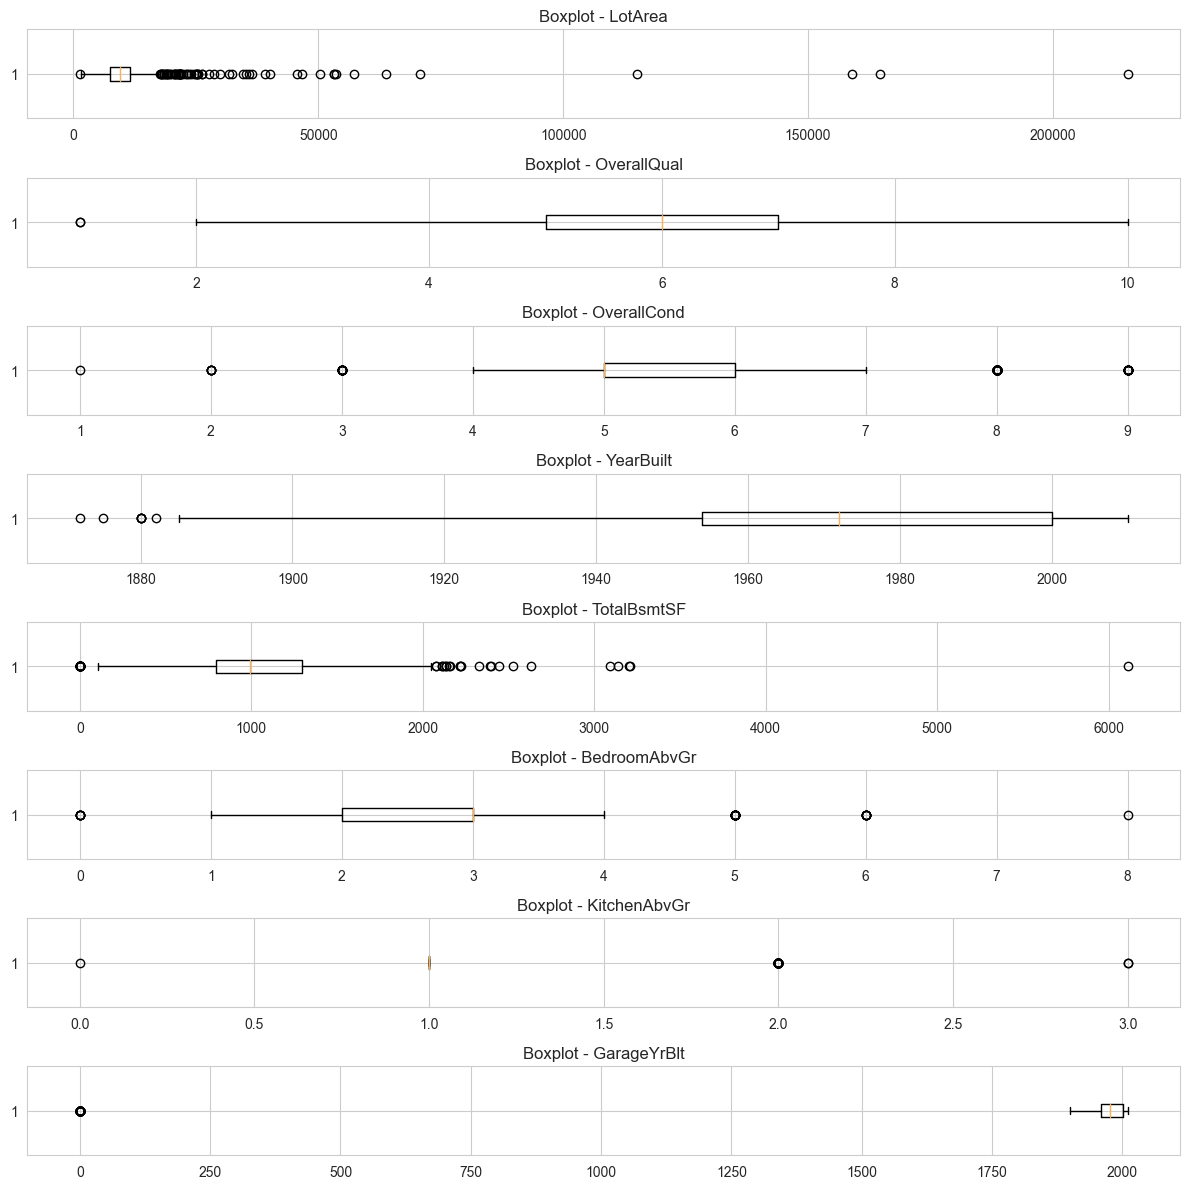

In [292]:
# PLOT BOXPLOT CHART FOR NUMERICAL COLUMNS WITH IDENFIED OUTLIERS VALUES

fig, axs = plt.subplots(len(outlier_numerical_columns), figsize=(12, 12))

for i, column in enumerate(outlier_numerical_columns):
    axs[i].boxplot(df_train_filled[column], vert=False)
    axs[i].set_title(f"Boxplot - {column}")

plt.tight_layout()
plt.show()

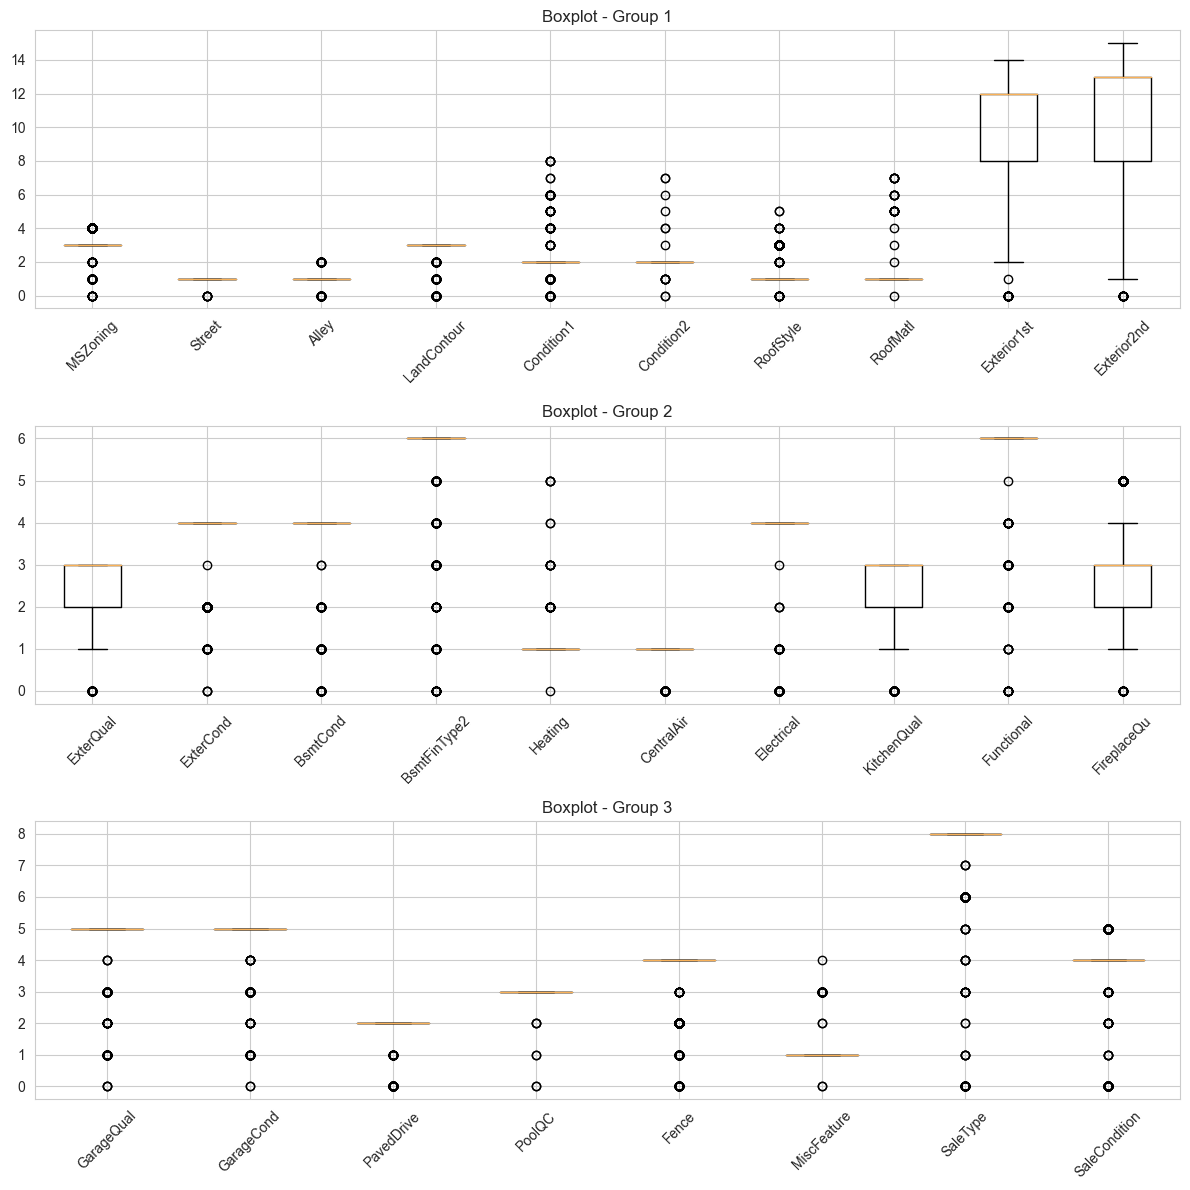

In [293]:
# PLOT BOXPLOT CHART FOR CATEGORICAL COLUMNS WITH IDENFIED OUTLIERS VALUES

num_plots = math.ceil(len(outlier_categorical_columns) / 10)

fig, axs = plt.subplots(num_plots, figsize=(12, 12))

for i in range(num_plots):
    start = i * 10
    end = min((i + 1) * 10, len(outlier_categorical_columns))
    columns_subset = outlier_categorical_columns[start:end]

    if num_plots > 1:
        axs_i = axs[i]
    else:
        axs_i = axs

    axs_i.boxplot(df_train_filled_encoded[columns_subset])
    axs_i.set_xticklabels(columns_subset, rotation=45)
    axs_i.set_title(f"Boxplot - Group {i + 1}")

plt.tight_layout()
plt.show()

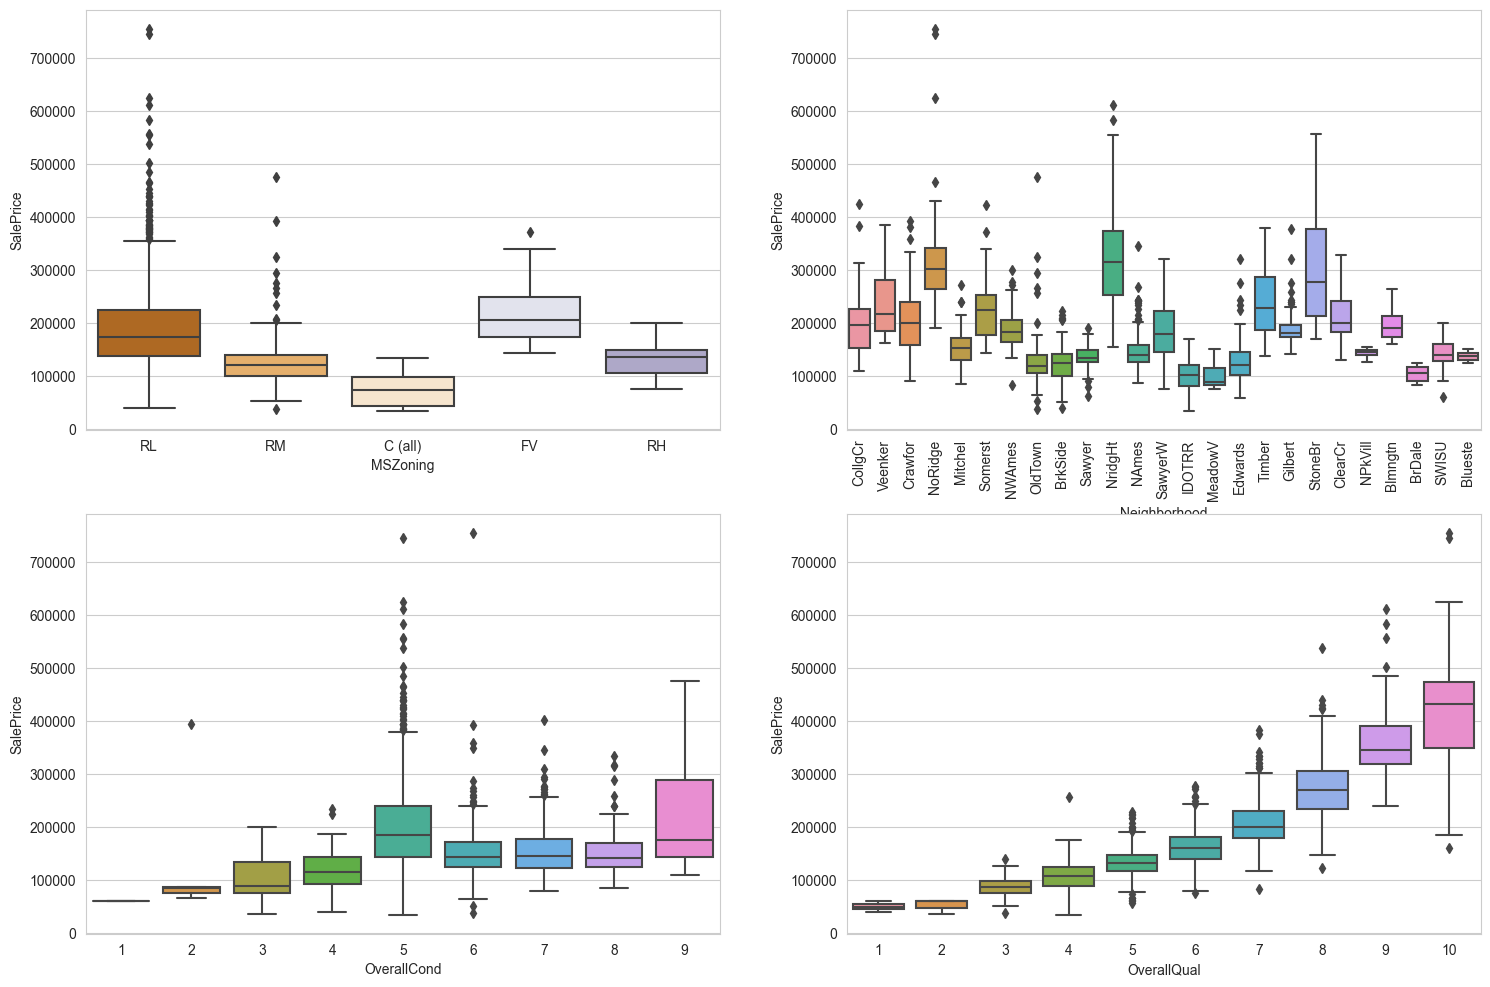

In [294]:
# Analyzing SalePrice columns with others


fig = plt.figure(figsize=(18, 12))

# Chart 1
fig.add_subplot(221)
# sns.countplot(df_train['MSZoning'])
sns.boxplot(x="MSZoning", y="SalePrice", data=df_train)

# Chart 2
fig.add_subplot(222)
# sns.boxplot(x='MSZoning', y='SalePrice', data=df_train)
ax222 = sns.boxplot(x="Neighborhood", y="SalePrice", data=df_train)

# Chart 3
fig.add_subplot(223)
# sns.boxplot(x='Neighborhood', y='SalePrice', data=df_train)
sns.boxplot(x="OverallCond", y="SalePrice", data=df_train)

# Chart 4
fig.add_subplot(224)
# sns.violinplot(x = 'OverallQual', y = 'SalePrice', data=df_train, palette='Set3', bw=.2, cut=1, split=True, linewidth=1)
sns.boxplot(x="OverallQual", y="SalePrice", data=df_train)

## Rotate ax222 by 90 degrees
ax222.tick_params(axis="x", labelrotation=90)

6) Existem dados faltantes?

Sim. Este item foi respodido na questão 4.

Quatro atributos (colunas) chamam a atenção por ter mais de 80% de dados faltantes (vide destaque em laranja na imagem acima).

In [295]:
# Calcular a porcentagem de valores ausentes em cada coluna com valores ausentes maiores que 0
missing_data = df_train.isnull().sum()[df_train.isnull().sum() > 0]
missing_data_percentage = missing_data / len(df_train) * 100

# Combinar as informações em um dataframe
missing_data_df = pd.concat(
    [missing_data, missing_data_percentage], axis=1, keys=["Total", "Percentage"]
)

# Ordenar os valores pela porcentagem de valores ausentes em ordem decrescente
missing_data_df = missing_data_df.sort_values(by="Percentage", ascending=False)

missing_data_df

,Total,Percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


7) Em existindo dados faltantes, crie duas novas bases a partir da original, em que não existam dados faltantes usando dois métodos diferentes.

A primeira base já foi criado anteriormente respondendo a questão 4. Chama-se "df_train_filled", onde foi analisado que entre os atributos que possuiam dados faltantes ou N/A alguns poderiam ser substituido por zero, outros por "none" e outros por "not answered". Possibilitando uma tratativa melhor dos dados.

O segundo método é um método simples de exclusão das instâncias que possui alguma variável N/A. O resultado disso é zerar por completo as instâncias da base nova (df_train_na)

In [296]:
df_train_na = df_train.dropna()

df_train_na.info()
df_train_na

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             0 non-null      int64  
 1   MSSubClass     0 non-null      int64  
 2   MSZoning       0 non-null      object 
 3   LotFrontage    0 non-null      float64
 4   LotArea        0 non-null      int64  
 5   Street         0 non-null      object 
 6   Alley          0 non-null      object 
 7   LotShape       0 non-null      object 
 8   LandContour    0 non-null      object 
 9   Utilities      0 non-null      object 
 10  LotConfig      0 non-null      object 
 11  LandSlope      0 non-null      object 
 12  Neighborhood   0 non-null      object 
 13  Condition1     0 non-null      object 
 14  Condition2     0 non-null      object 
 15  BldgType       0 non-null      object 
 16  HouseStyle     0 non-null      object 
 17  OverallQual    0 non-null      int64  
 18  OverallCond    0 non-null  

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


8) É possível agregar dados na base? Quais?

Sim, é possível, porém a base de dados já possui vários atributos, tornando a adição desnecessário para a predição do SalePriec.

Uma opção de adição de dados seria o de nível de criminalidade nos bairros das casas ou até mesmo o preechimento dos dados faltantes como foi feito.

9) Qual a proporção entre as clases?

Resposta no gráfico abaixo

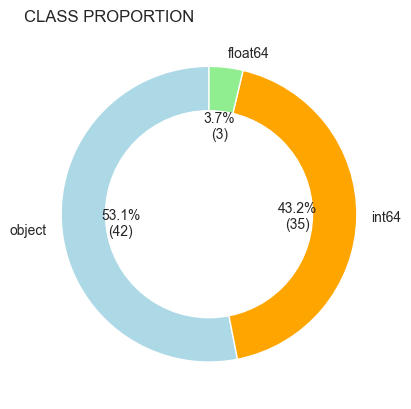

In [297]:
dtypes_count = df_train.dtypes.value_counts()
sizes = dtypes_count.values
labels = dtypes_count.index.astype(str)
colors = ["lightblue", "orange", "lightgreen"]

# CHART
fig, ax = plt.subplots()
ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct=lambda pct: f"{pct:.1f}%\n({int(pct/100*sizes.sum())})",
    startangle=90,
)
centre_circle = plt.Circle((0, 0), 0.70, fc="white")
fig.gca().add_artist(centre_circle)
plt.title("CLASS PROPORTION", loc="left")
plt.show()

10) É necessário dimuir a dimensionalidade? Porquê?

Sim, faz-se necessário essa redução ainda mais que algumas variáveis possui pouca correlação com o target do trabalho que é o SalePrice (preço do imóvel). E como visto, algumas colunas?atributos, possuem mais de 90% de dados faltantes, sendo desnecessário ter essas colunas para nossas análises.

11) Apresente uma nova base com seleção de atributos usando o algoritmo Relief.

Vide códigos abaixo cujo produto é df_train_relief

# TERRROR -> VAMOS REFAZER!!!!!!!!!!!

In [298]:
# RELIEFF METHOD APPLIED

# Separate target column from the others
X = df_train_filled_encoded.drop("SalePrice", axis=1).drop(
    "Id", axis=1
)  # Using df_train_filled_encoded the categorical columns are already converted to numerical
y = df_train_filled_encoded["SalePrice"].copy()
# END OF Separate target column from the others

# ReliefF
relief = ReliefF(n_neighbors=10)  # https://epistasislab.github.io/scikit-rebate/using/

relief.fit(X.values, y.values)
feature_scores = (
    relief.feature_importances_
)  # Extract the weights calculated by ReliefF

# Select the best columns that affect SalePrice
selected_features = X.columns[
    relief.top_features_
]  # ????????????? Por algum motibo ele não está filtrando as 20 melhores, conforme especificado em n_features_to_select
X_selected = X[
    selected_features
]  # ????????? Alternativa feita abaixo para filtrar os 20 atributos com maior influencia na variável alvo
print("Atributos selecionados:")
print(selected_features)
print("\nOrdem de importância dos atributos:")
relief_result = sorted(
    zip(selected_features, feature_scores), key=lambda x: x[1], reverse=True
)
print(relief_result)
# END OF Select the best columns that affect SalePrice

Atributos selecionados:
Index(['GrLivArea', 'OverallQual', '1stFlrSF', 'TotalBsmtSF', 'GarageCars',
       'FullBath', 'GarageArea', 'FireplaceQu', 'TotRmsAbvGrd', 'Fireplaces',
       'KitchenQual', 'BsmtQual', 'GarageFinish', '2ndFlrSF', 'Neighborhood',
       'ExterQual', 'BsmtFinSF1', 'GarageType', 'BedroomAbvGr', 'YearBuilt',
       'MasVnrArea', 'MSSubClass', 'YearRemodAdd', 'HouseStyle', 'HalfBath',
       'BsmtUnfSF', 'Foundation', 'MasVnrType', 'BsmtExposure', 'MSZoning',
       'LotFrontage', 'BsmtFullBath', 'BsmtFinType1', 'BldgType', 'HeatingQC',
       'WoodDeckSF', 'LotShape', 'OpenPorchSF', 'Exterior1st', 'OverallCond',
       'Exterior2nd', 'GarageQual', 'RoofStyle', 'LotArea', 'GarageCond',
       'GarageYrBlt', 'ScreenPorch', 'BsmtCond', 'BsmtFinType2', 'SaleType',
       'LotConfig', 'LandContour', 'KitchenAbvGr', 'CentralAir', 'YrSold',
       'LandSlope', 'BsmtFinSF2', 'EnclosedPorch', 'SaleCondition', 'Alley',
       'Fence', 'ExterCond', 'Condition1', 'Electrical

In [299]:
# Alternativa to create a new dataframe with the first 20% of best atributes (columns) that affect target atribute.
df_train_relief = pd.DataFrame
top_relief_result = [
    item[0] for item in relief_result[: int(len(relief_result) * 0.2)]
]  # Select the first 20% (0.2)
df_train_relief = df_train_filled_encoded[top_relief_result].copy()
df_train_relief = df_train_relief.join(df_train["SalePrice"])
df_train_relief

,GarageYrBlt,BsmtFinSF1,RoofStyle,OpenPorchSF,Fence,BsmtFinType2,ExterCond,BsmtFinSF2,CentralAir,LandSlope,KitchenAbvGr,MSZoning,Alley,LotArea,BsmtQual,SalePrice
0,2003.0,706,1,61,4,6,4,0,1,0,1,3,1,8450,2,208500
1,1976.0,978,1,0,4,6,4,0,1,0,1,3,1,9600,2,181500
2,2001.0,486,1,42,4,6,4,0,1,0,1,3,1,11250,2,223500
3,1998.0,216,1,35,4,6,4,0,1,0,1,3,1,9550,4,140000
4,2000.0,655,1,84,4,6,4,0,1,0,1,3,1,14260,2,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1999.0,0,1,40,4,6,4,0,1,0,1,3,1,7917,2,175000
1456,1978.0,790,1,0,2,5,4,163,1,0,1,3,1,13175,2,210000
1457,1941.0,275,1,60,0,6,2,0,1,0,1,3,1,9042,4,266500
1458,1950.0,49,3,0,4,5,4,1029,1,0,1,3,1,9717,4,142125


12) Apresente uma nova base com variáveis discretizadas por dois métodos diferentes;

Os dois métodos será aplicados a base df_train_relief.

Os métodos escolhidos foram o Binning (Discretização por Intervalos) e K-Mean.

A primeira base modificada chama-se df_train_relief_binning e a segunda df_train_relief_kmean.

Ambas oriundas de df_train_filled_encoded.

In [300]:
# BINNING METHOD TO DISCRETIZER
# from sklearn.preprocessing import KBinsDiscretizer

discretizer = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="uniform")

df_train_relief_binning = df_train_relief.drop(
    "SalePrice", axis=1
)  # Remove a coluna "SalePrice" do dataframe

for column in df_train_relief_binning.columns:
    if pd.api.types.is_numeric_dtype(df_train_relief_binning[column]):
        column_values = df_train_relief_binning[column].values.reshape(-1, 1)
        column_binned = discretizer.fit_transform(column_values)
        df_train_relief_binning[column] = column_binned.flatten()

df_train_relief_binning["SalePrice"] = df_train["SalePrice"]

df_train_relief_binning

,GarageYrBlt,BsmtFinSF1,RoofStyle,OpenPorchSF,Fence,BsmtFinType2,ExterCond,BsmtFinSF2,CentralAir,LandSlope,KitchenAbvGr,MSZoning,Alley,LotArea,BsmtQual,SalePrice
0,4.0,0.0,1.0,0.0,4.0,4.0,4.0,0.0,4.0,0.0,1.0,3.0,2.0,0.0,2.0,208500
1,4.0,0.0,1.0,0.0,4.0,4.0,4.0,0.0,4.0,0.0,1.0,3.0,2.0,0.0,2.0,181500
2,4.0,0.0,1.0,0.0,4.0,4.0,4.0,0.0,4.0,0.0,1.0,3.0,2.0,0.0,2.0,223500
3,4.0,0.0,1.0,0.0,4.0,4.0,4.0,0.0,4.0,0.0,1.0,3.0,2.0,0.0,4.0,140000
4,4.0,0.0,1.0,0.0,4.0,4.0,4.0,0.0,4.0,0.0,1.0,3.0,2.0,0.0,2.0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,4.0,0.0,1.0,0.0,4.0,4.0,4.0,0.0,4.0,0.0,1.0,3.0,2.0,0.0,2.0,175000
1456,4.0,0.0,1.0,0.0,2.0,4.0,4.0,0.0,4.0,0.0,1.0,3.0,2.0,0.0,2.0,210000
1457,4.0,0.0,1.0,0.0,0.0,4.0,2.0,0.0,4.0,0.0,1.0,3.0,2.0,0.0,4.0,266500
1458,4.0,0.0,3.0,0.0,4.0,4.0,4.0,3.0,4.0,0.0,1.0,3.0,2.0,0.0,4.0,142125


In [301]:
df_train_relief_kmean = df_train_relief.copy()

kmeans = KMeans(n_clusters=5, random_state=42)

for column in df_train_relief.columns:
    if pd.api.types.is_numeric_dtype(df_train_relief[column]):
        column_values = df_train_relief[column].values.reshape(-1, 1)
        discretized_values = kmeans.fit_transform(column_values)

        for i in range(discretized_values.shape[1]):
            new_column_name = f"{column}_bin_{i+1}"
            df_train_relief_kmean[new_column_name] = discretized_values[:, i]


df_train_relief_kmean

c:\Users\vinic\repositories\house-prices-prediction-ppgia\.env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\vinic\repositories\house-prices-prediction-ppgia\.env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\vinic\repositories\house-prices-prediction-ppgia\.env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\vinic\repositories\house-prices-prediction-ppgia\.env\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 

,GarageYrBlt,BsmtFinSF1,RoofStyle,OpenPorchSF,Fence,BsmtFinType2,ExterCond,BsmtFinSF2,CentralAir,LandSlope,KitchenAbvGr,MSZoning,Alley,LotArea,BsmtQual,SalePrice,GarageYrBlt_bin_1,GarageYrBlt_bin_2,GarageYrBlt_bin_3,GarageYrBlt_bin_4,GarageYrBlt_bin_5,BsmtFinSF1_bin_1,BsmtFinSF1_bin_2,BsmtFinSF1_bin_3,BsmtFinSF1_bin_4,BsmtFinSF1_bin_5,RoofStyle_bin_1,RoofStyle_bin_2,RoofStyle_bin_3,RoofStyle_bin_4,RoofStyle_bin_5,OpenPorchSF_bin_1,OpenPorchSF_bin_2,OpenPorchSF_bin_3,OpenPorchSF_bin_4,OpenPorchSF_bin_5,Fence_bin_1,Fence_bin_2,Fence_bin_3,Fence_bin_4,Fence_bin_5,BsmtFinType2_bin_1,BsmtFinType2_bin_2,BsmtFinType2_bin_3,BsmtFinType2_bin_4,BsmtFinType2_bin_5,ExterCond_bin_1,ExterCond_bin_2,ExterCond_bin_3,ExterCond_bin_4,ExterCond_bin_5,BsmtFinSF2_bin_1,BsmtFinSF2_bin_2,BsmtFinSF2_bin_3,BsmtFinSF2_bin_4,BsmtFinSF2_bin_5,CentralAir_bin_1,CentralAir_bin_2,CentralAir_bin_3,CentralAir_bin_4,CentralAir_bin_5,LandSlope_bin_1,LandSlope_bin_2,LandSlope_bin_3,LandSlope_bin_4,LandSlope_bin_5,KitchenAbvGr_bin_1,KitchenAbvGr_bin_2,KitchenAbvGr_bin_3,KitchenAbvGr_bin_4,KitchenAbvGr_bin_5,MSZoning_bin_1,MSZoning_bin_2,MSZoning_bin_3,MSZoning_bin_4,MSZoning_bin_5,Alley_bin_1,Alley_bin_2,Alley_bin_3,Alley_bin_4,Alley_bin_5,LotArea_bin_1,LotArea_bin_2,LotArea_bin_3,LotArea_bin_4,LotArea_bin_5,BsmtQual_bin_1,BsmtQual_bin_2,BsmtQual_bin_3,BsmtQual_bin_4,BsmtQual_bin_5,SalePrice_bin_1,SalePrice_bin_2,SalePrice_bin_3,SalePrice_bin_4,SalePrice_bin_5
0,2003.0,706,1,61,4,6,4,0,1,0,1,3,1,8450,2,208500,73.258741,2003.0,1.40678,43.436975,24.832143,682.149915,78.973214,596.638158,278.413333,4938.0,0.0,2.0,1.0,3.222222,1.0,58.395442,63.495,8.556322,172.5,399.0,0.0,3.0,2.0,4.000000e+00,1.0,0.0,5.365385,3.233333,1.0,2.0,0.0,2.0,3.0,4.0,1.0,0.732871,701.178571,193.903226,1083.75,447.0,0.0,1.0,0.0,0.0,0.0,2.359224e-16,1.0,2.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,2.0,1.0,3.0,0.0,1.0,1.0,0.0,0.0,1564.059165,155063.5,37410.0,3138.114667,8073.73057,2.0,0.0,2.0,1.0,1.0,34270.289796,142675.84466,90752.429066,366292.333333,36224.992537
1,1976.0,978,1,0,4,6,4,0,1,0,1,3,1,9600,2,181500,46.258741,1976.0,25.59322,16.436975,2.167857,954.149915,193.026786,324.638158,550.413333,4666.0,0.0,2.0,1.0,3.222222,1.0,2.604558,124.495,52.443678,233.5,460.0,0.0,3.0,2.0,4.000000e+00,1.0,0.0,5.365385,3.233333,1.0,2.0,0.0,2.0,3.0,4.0,1.0,0.732871,701.178571,193.903226,1083.75,447.0,0.0,1.0,0.0,0.0,0.0,2.359224e-16,1.0,2.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,2.0,1.0,3.0,0.0,1.0,1.0,0.0,0.0,414.059165,153913.5,36260.0,4288.114667,6923.73057,2.0,0.0,2.0,1.0,1.0,7270.289796,169675.84466,63752.429066,393292.333333,63224.992537
2,2001.0,486,1,42,4,6,4,0,1,0,1,3,1,11250,2,223500,71.258741,2001.0,0.59322,41.436975,22.832143,462.149915,298.973214,816.638158,58.413333,5158.0,0.0,2.0,1.0,3.222222,1.0,39.395442,82.495,10.443678,191.5,418.0,0.0,3.0,2.0,4.000000e+00,1.0,0.0,5.365385,3.233333,1.0,2.0,0.0,2.0,3.0,4.0,1.0,0.732871,701.178571,193.903226,1083.75,447.0,0.0,1.0,0.0,0.0,0.0,2.359224e-16,1.0,2.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,2.0,1.0,3.0,0.0,1.0,1.0,0.0,0.0,1235.940835,152263.5,34610.0,5938.114667,5273.73057,2.0,0.0,2.0,1.0,1.0,49270.289796,127675.84466,105752.429066,351292.333333,21224.992537
3,1998.0,216,1,35,4,6,4,0,1,0,1,3,1,9550,4,140000,68.258741,1998.0,3.59322,38.436975,19.832143,192.149915,568.973214,1086.638158,211.586667,5428.0,0.0,2.0,1.0,3.222222,1.0,32.395442,89.495,17.443678,198.5,425.0,0.0,3.0,2.0,4.000000e+00,1.0,0.0,5.365385,3.233333,1.0,2.0,0.0,2.0,3.0,4.0,1.0,0.732871,701.178571,193.903226,1083.75,447.0,0.0,1.0,0.0,0.0,0.0,2.359224e-16,1.0,2.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,2.0,1.0,3.0,0.0,1.0,1.0,0.0,0.0,464.059165,153963.5,36310.0,4238.114667,6973.73057,0.0,2.0,4.0,3.0,1.0,34229.710204,211175.84466,22252.429066,434792.333333,104724.992537
4,2000.0,655,1,84,4,6,4,0,1,0,1,3,1,14260,2,250000,70.258741,2000.0,1.59322,40.436975,21.832143,631.149915,129.973214,647.638158,227.413333,4989.0,0.0,2.0,1.0,3.222222,1.0,81.395442,40.495,31.556322,149.5,376.0,0.0,3.0,2.0,4.000000e

In [302]:
# Stats of df_relief
stats_relief = df_train_relief.describe().transpose()
stats_relief.rename(columns=lambda x: f"relief_{x}", inplace=True)

# Stats of df_train_relief_binning
stats_binning = df_train_relief_binning.describe().transpose()
stats_binning.rename(columns=lambda x: f"binning_{x}", inplace=True)

# Stats of df_train_relief_kmean
stats_kmean = df_train_relief_kmean.describe().transpose()
stats_kmean.rename(columns=lambda x: f"kmean_{x}", inplace=True)

# # Comparison between all
# stats_comparison = pd.concat([stats_relief, stats_binning, stats_kmean], axis=1)
# stats_comparison

In [303]:
stats_binning

,binning_count,binning_mean,binning_std,binning_min,binning_25%,binning_50%,binning_75%,binning_max
GarageYrBlt,1451.0,3.776706,0.918639,0.0,4.0,4.0,4.0,4.0
BsmtFinSF1,1451.0,0.086837,0.298339,0.0,0.0,0.0,0.0,4.0
RoofStyle,1451.0,1.410062,0.830875,0.0,1.0,1.0,1.0,4.0
OpenPorchSF,1451.0,0.178498,0.486202,0.0,0.0,0.0,0.0,4.0
Fence,1451.0,3.501723,1.085562,0.0,4.0,4.0,4.0,4.0
BsmtFinType2,1451.0,3.738112,0.863227,0.0,4.0,4.0,4.0,4.0
ExterCond,1451.0,3.731909,0.733773,0.0,4.0,4.0,4.0,4.0
BsmtFinSF2,1451.0,0.099242,0.424840,0.0,0.0,0.0,0.0,4.0
CentralAir,1451.0,3.738112,0.989769,0.0,4.0,4.0,4.0,4.0
LandSlope,1451.0,0.125431,0.554089,0.0,0.0,0.0,0.0,4.0


In [304]:
stats_kmean

,kmean_count,kmean_mean,kmean_std,kmean_min,kmean_25%,kmean_50%,kmean_75%,kmean_max
GarageYrBlt,1451.0,1867.914542,454.981043,0.000000,1958.000000,1977.000000,2001.000000,2010.000000
BsmtFinSF1,1451.0,442.274983,455.369276,0.000000,0.000000,381.000000,707.000000,5644.000000
RoofStyle,1451.0,1.411440,0.835988,0.000000,1.000000,1.000000,1.000000,5.000000
OpenPorchSF,1451.0,46.422467,66.060150,0.000000,0.000000,24.000000,68.000000,547.000000
Fence,1451.0,3.501723,1.085562,0.000000,4.000000,4.000000,4.000000,4.000000
...,...,...,...,...,...,...,...,...
SalePrice_bin_1,1451.0,56238.429297,56270.667244,229.710204,20770.289796,43229.710204,70900.000000,580770.289796
SalePrice_bin_2,1451.0,176732.641673,64361.507269,1175.844660,138725.844660,189675.844660,221675.844660,403824.155340
SalePrice_bin_3,1451.0,70018.635266,73079.463451,247.570934,20747.570934,47252.429066,96252.429066,637252.429066
SalePrice_bin_4,1451.0,394782.467494,76193.683701,8140.666667,360792.333333,412292.333333,444892.333333,539892.333333


In [305]:
stats_relief

,relief_count,relief_mean,relief_std,relief_min,relief_25%,relief_50%,relief_75%,relief_max
GarageYrBlt,1451.0,1867.914542,454.981043,0.0,1958.0,1977.0,2001.0,2010.0
BsmtFinSF1,1451.0,442.274983,455.369276,0.0,0.0,381.0,707.0,5644.0
RoofStyle,1451.0,1.411440,0.835988,0.0,1.0,1.0,1.0,5.0
OpenPorchSF,1451.0,46.422467,66.060150,0.0,0.0,24.0,68.0,547.0
Fence,1451.0,3.501723,1.085562,0.0,4.0,4.0,4.0,4.0
BsmtFinType2,1451.0,5.584425,1.204133,0.0,6.0,6.0,6.0,6.0
ExterCond,1451.0,3.731909,0.733773,0.0,4.0,4.0,4.0,4.0
BsmtFinSF2,1451.0,46.838043,161.777324,0.0,0.0,0.0,0.0,1474.0
CentralAir,1451.0,0.934528,0.247442,0.0,1.0,1.0,1.0,1.0
LandSlope,1451.0,0.062715,0.277045,0.0,0.0,0.0,0.0,2.0


14) Indique os gráficos de dispersão dos atributos.

Resposta no código abaixo.

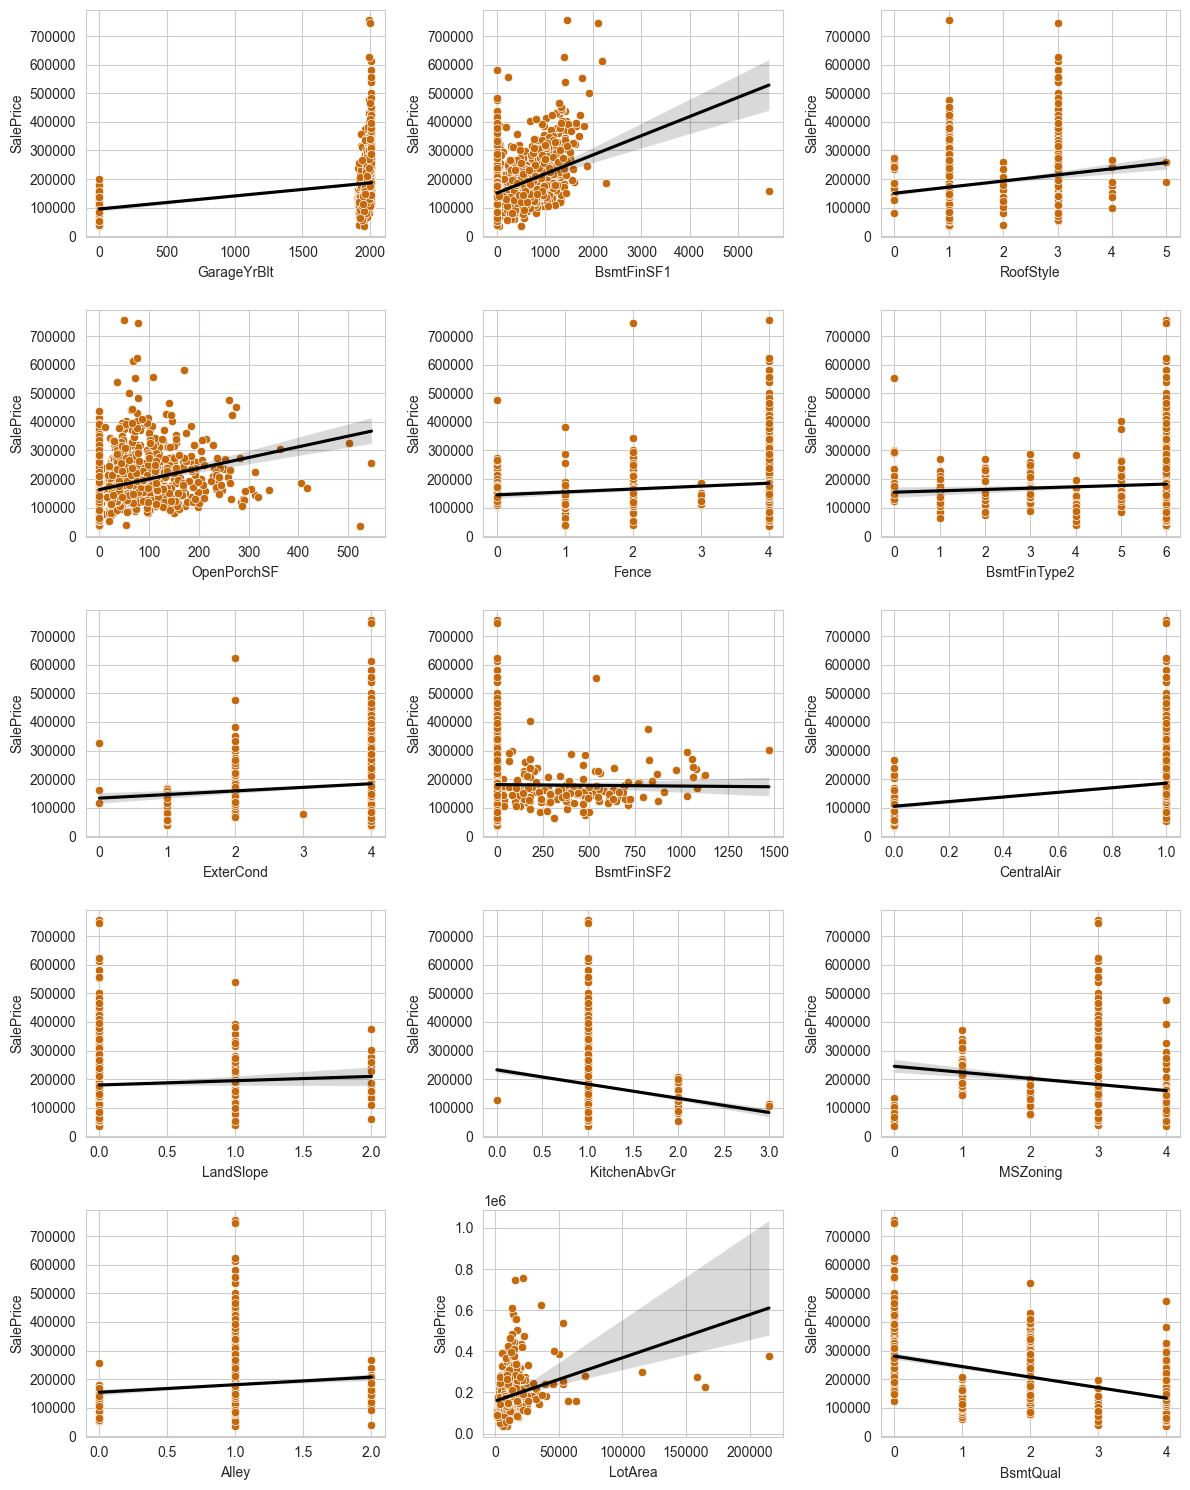

In [306]:
sns.set_palette("PuOr")
sns.set_style("whitegrid")

fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(12, 15))

for i, column in enumerate(df_train_relief.columns):
    if column == "SalePrice":
        continue
    ax = axs[i // 3, i % 3]
    sns.scatterplot(x=column, y="SalePrice", data=df_train_relief, ax=ax)
    sns.regplot(
        x=column,
        y="SalePrice",
        data=df_train_relief,
        ax=ax,
        scatter=False,
        color="black",
    )
    ax.set_xlabel(column)
    ax.set_ylabel("SalePrice")

plt.tight_layout()
plt.show()

# GROUP OF QUESTIONS #3:
# CLASSIFICATION TASK

There are 17 question in this group and each question will be in it own markdown field below.

In [307]:
# carregando os datos de treinamento e validação
train = df_train_filled_encoded.copy()
test = df_test_filled_encoded.copy()

## Descretizer Sale Price
Explanaition why sale price be discretized

In [308]:
target_variable = "SalePrice"

# Ajustar e transformar os dados de treinamento e teste com MinMaxScaler
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[[target_variable]])
test_scaled = scaler.fit_transform(test[[target_variable]])

# Instanciar a classe KBinsDiscretizer com 5 bins (faixas)
discretizer = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile")

# Aplicar o discretizer nos dados 'SalePrice' escalonados
train_preco_discretizado = discretizer.fit_transform(train_scaled)
test_preco_discretizado = discretizer.fit_transform(test_scaled)

# Adicionar a nova coluna de categorias ao dataframe original
train["SalePriceCategorical"] = pd.Series(train_preco_discretizado.reshape(-1))
test["SalePriceCategorical"] = pd.Series(test_preco_discretizado.reshape(-1))

target_variable = "SalePriceCategorical"

# Renomear as categorias
train[target_variable].replace(
    {
        0: "House Price 1",
        1: "House Price 2",
        2: "House Price 3",
        3: "House Price 4",
        4: "House Price 5",
    },
    inplace=True,
)
test[target_variable].replace(
    {
        0: "House Price 1",
        1: "House Price 2",
        2: "House Price 3",
        3: "House Price 4",
        4: "House Price 5",
    },
    inplace=True,
)

train.dropna(inplace=True)
test.dropna(inplace=True)

## ARFF Files - Use in Weka

In [309]:
# Diretório do repositório git
git_dir = get_git_root(os.getcwd())

# Diretório de arquivos de dados
data_dir = os.path.join(git_dir, "data")

# Definir o diretório onde os arquivos estão localizados
dir = data_dir

# Iterar sobre os arquivos no diretório e verificar se a extensão é .arff
arquivos_arff = [arquivo for arquivo in os.listdir(dir) if arquivo.endswith(".arff")]


# Exibir os arquivos encontrados
print(arquivos_arff)


if not arquivos_arff in ["train.arff", "test.arff"]:
    # converter dataframe pandas para arquivo arff
    pandas2arff(train.drop(columns="SalePrice"), "train.arff", wekaname="train_data")
    pandas2arff(test.drop(columns="SalePrice"), "test.arff", wekaname="test_data")

[]


## Load .arff data

In [310]:
# Inicializar JVM
jvm.start()

# Diretório do repositório git
git_dir = get_git_root(os.getcwd())

# Diretório de dados de entrada
data_dir = os.path.join(git_dir, "data")

# Diretório de arquivos de saída
output_dir = os.path.join(git_dir, "output")

# Carregar o conjunto de dados
loader = Loader("weka.core.converters.ArffLoader")
train_data = loader.load_file(os.path.join(data_dir, "train.arff"))
test_data = loader.load_file(os.path.join(data_dir, "test.arff"))

# usado para informar ao Weka que a classe é a última coluna do conjunto de dados
train_data.class_is_last()
test_data.class_is_last()

DEBUG:weka.core.jvm:Adding bundled jars
DEBUG:weka.core.jvm:Classpath=['C:\\Users\\vinic\\repositories\\house-prices-prediction-ppgia\\.env\\Lib\\site-packages\\javabridge\\jars\\rhino-1.7R4.jar', 'C:\\Users\\vinic\\repositories\\house-prices-prediction-ppgia\\.env\\Lib\\site-packages\\javabridge\\jars\\runnablequeue.jar', 'C:\\Users\\vinic\\repositories\\house-prices-prediction-ppgia\\.env\\Lib\\site-packages\\javabridge\\jars\\cpython.jar', 'c:\\Users\\vinic\\repositories\\house-prices-prediction-ppgia\\.env\\lib\\site-packages\\weka\\lib\\python-weka-wrapper.jar', 'c:\\Users\\vinic\\repositories\\house-prices-prediction-ppgia\\.env\\lib\\site-packages\\weka\\lib\\weka.jar']
DEBUG:weka.core.jvm:MaxHeapSize=default
DEBUG:weka.core.jvm:Package support disabled


## C4.5

1) Apresentar a árvore de decisão resultante com os parâmetros padrão do classificador

In [311]:
# Instanciar o classificador C45
c45 = Classifier(classname="weka.classifiers.trees.J48")

# Treinar o algoritmo usando o conjunto de dados de treinamento
c45.build_classifier(train_data)

# Salvar a árvore em formato .dot
with open(os.path.join(output_dir, "c45tree.dot"), "w") as f:
    f.write(c45.graph)

# Converter o arquivo .dot em um arquivo .pdf
os.system(
    f"dot -Tpdf {os.path.join(output_dir, 'c45tree.dot')} -o {os.path.join(output_dir, 'c45tree.pdf')}"
)

os.remove(os.path.join(output_dir, "c45tree.dot"))

2) Analisar a árvore gerada da maneira mais completa possível;
O algoritmo C4.5 é usado para criar árvores de decisão com base em um conjunto de dados rotulados, usando medidas de entropia para determinar o melhor atributo em cada nó da árvore.


discursiva

3) Indicar qual é a taxa de acerto obtida utilizando o método de validação cruzada com fator 10;

In [313]:
# Avaliar o classificador REPtree usando validação cruzada de 10 folds
evaluation = Evaluation(train_data)
evaluation.crossvalidate_model(c45, train_data, 10, Random(1))

# Imprimir a taxa de acerto geral do modelo
print("Taxa de acerto geral [C4.5]: ", round(evaluation.percent_correct, 2))

Taxa de acerto geral [C4.5]:  24.06


4) Apresentar a matriz de confusão;

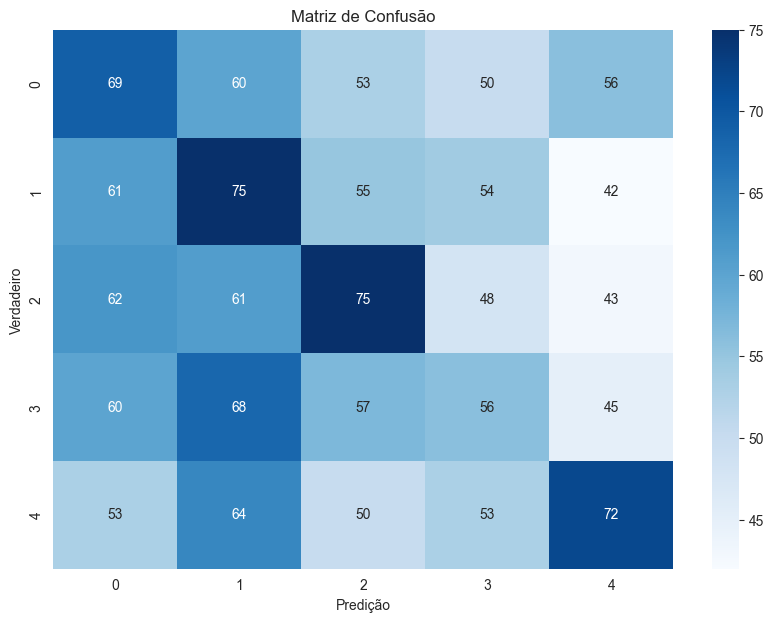

In [314]:
# Obter as previsões do modelo para o conjunto de teste
c45_predictions = evaluation.predictions

# Retonar o dataframe
c45_predictions_df = evaluation_to_dataframe(c45_predictions)

# Gerar matriz de confusão
conf_matrix = confusion_matrix(
    c45_predictions_df["actual"], c45_predictions_df["predicted"]
)

# Criar um gráfico de heatmap com a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues")
plt.xlabel("Predição")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()

5) A partir da matriz de confusão, indicar quais pares de classes são confundidas com mais frequência;

6) Qual a taxa de acerto por classe?

In [318]:
# Calcular as contagens de verdadeiros positivos, falsos positivos e falsos negativos
true_positives = np.diag(conf_matrix)
false_positives = np.sum(conf_matrix, axis=0) - true_positives
false_negatives = np.sum(conf_matrix, axis=1) - true_positives

# Calcular a taxa de acerto para cada classe
accuracy_per_class = true_positives / (
    true_positives + false_positives + false_negatives
)

# Converter a taxa de acerto em um dataframe
accuracy_per_class_df = pd.DataFrame(accuracy_per_class, columns=["Acerto/Classe"])

# Exibir o dataframe com a taxa de acerto por classe
print(accuracy_per_class_df)

   Acerto/Classe
0       0.092081
1       0.134766
2       0.133574
3       0.095703
4       0.099783


## REPTree

In [ ]:
# Instanciar o classificador REPtree
reptree = Classifier(classname="weka.classifiers.trees.REPTree")

# Treinar o algoritmo usando o conjunto de dados de treinamento
reptree.build_classifier(train_data)

# Salvar a árvore em formato .dot
with open(os.path.join(output_dir, "reptree.dot"), "w") as f:
    f.write(reptree.graph)

# Converter o arquivo .dot em um arquivo .pdf
os.system(
    f"dot -Tpdf {os.path.join(output_dir, 'reptree.dot')} -o {os.path.join(output_dir, 'reptree.pdf')}"
)

os.remove(os.path.join(output_dir, "reptree.dot"))

7) Use o algoritmo REPtree para gerar uma árvore de decisão para a base e indique-a

In [ ]:
# Avaliar o classificador REPtree usando validação cruzada de 10 folds
evaluation = Evaluation(train_data)
evaluation.crossvalidate_model(reptree, train_data, 10, Random(1))

# Imprimir a taxa de acerto geral do modelo
print("Taxa de acerto geral [REPTree]:", evaluation.percent_correct)